# Utilities

In [ ]:
#libs
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#pre-processing
from sklearn.model_selection import train_test_split

#models
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.ensemble import RandomForestClassifier 

#evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy.stats import friedmanchisquare, wilcoxon
from tensorflow.keras.utils import to_categorical

%matplotlib inline

In [ ]:
def drawROC(my_predict):
  n_classes = 3
  lw = 2
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(to_categorical(test_labels, 3)[:, i], to_categorical(my_predict, 3)[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  
  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(test_labels, 3).ravel(), to_categorical(my_predict, 3).ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
  
  # Plot all ROC curves
  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()


In [ ]:
def removeLabels(data, true_labels, ratio):
  n_total_samples = len(data)
  n_unlabelled_points = int(round(n_total_samples * ratio))
  indices = np.arange(n_total_samples)
  unlabelled_set = indices[n_unlabelled_points:]
  masked_labels = np.copy(true_labels)
  masked_labels[unlabelled_set] = -1
  return masked_labels, unlabelled_set


# Data loading

*Data loaded is already prereosessed from part A, task 1.

In [ ]:
data = pd.read_pickle('task1_data_balanced')

In [ ]:
labels = data.pop('readmitted').astype(int)

In [ ]:
train_dataset, test_dataset, train_labels, test_labels = train_test_split(data, labels, test_size=0.33)

# Label Propagation

In [ ]:
def myLabelPropagation(ratio):
  masked_labels, unlabeled_set = removeLabels(train_dataset, train_labels, 1-ratio)
  myProp = LabelPropagation(kernel='knn', max_iter=10000)
  start = time.time()
  myProp.fit(train_dataset, masked_labels)
  stop = time.time()
  print("Training time: " + str(stop - start))
  pred = np.array(myProp.predict(test_dataset))
  print(classification_report(test_labels,pred))
  drawROC(pred)
  return myProp.score(test_dataset, test_labels)

## Fully supervised - Baseline

Training time: 336.6852903366089
              precision    recall  f1-score   support

           0       0.81      0.50      0.61      2755
           1       0.79      0.67      0.73      5068
           2       0.82      0.95      0.88     11241

    accuracy                           0.81     19064
   macro avg       0.80      0.71      0.74     19064
weighted avg       0.81      0.81      0.80     19064



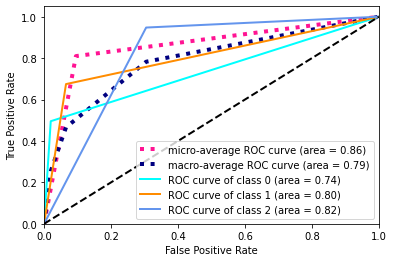

In [ ]:
lp_base = myLabelPropagation(0)

## 10% Unlabelled

Training time: 344.76148319244385
              precision    recall  f1-score   support

           0       0.79      0.48      0.60      2755
           1       0.77      0.66      0.71      5068
           2       0.81      0.94      0.87     11241

    accuracy                           0.80     19064
   macro avg       0.79      0.69      0.73     19064
weighted avg       0.80      0.80      0.79     19064



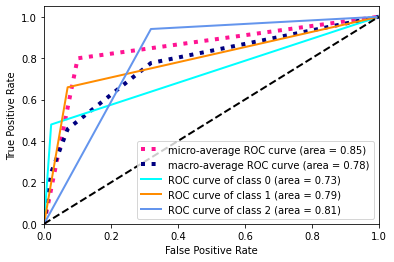

In [ ]:
lp_10 = myLabelPropagation(0.1)

## 20% Unlabelled

Training time: 343.0342490673065
              precision    recall  f1-score   support

           0       0.79      0.46      0.58      2755
           1       0.76      0.65      0.70      5068
           2       0.80      0.94      0.86     11241

    accuracy                           0.79     19064
   macro avg       0.78      0.68      0.71     19064
weighted avg       0.79      0.79      0.78     19064



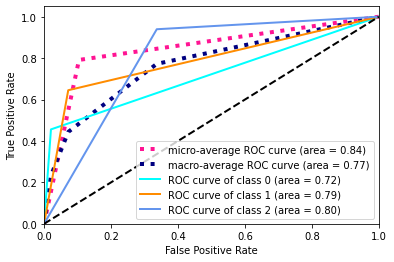

In [ ]:
lp_20 = myLabelPropagation(0.2)

## 50% Unlabelled

/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=10000 was reached without convergence.
  category=ConvergenceWarning


Training time: 367.14054131507874
              precision    recall  f1-score   support

           0       0.38      0.47      0.42      2755
           1       0.72      0.52      0.60      5068
           2       0.78      0.83      0.81     11241

    accuracy                           0.70     19064
   macro avg       0.63      0.61      0.61     19064
weighted avg       0.71      0.70      0.70     19064



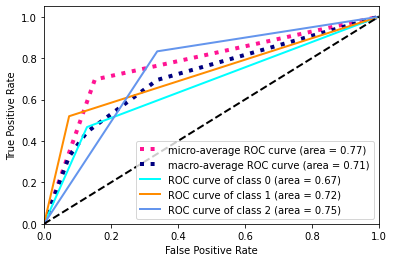

In [ ]:
lp_50 = myLabelPropagation(0.5)

## 90% Unlabelled

/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=10000 was reached without convergence.
  category=ConvergenceWarning


Training time: 368.8286008834839
              precision    recall  f1-score   support

           0       0.15      0.96      0.26      2755
           1       0.71      0.07      0.12      5068
           2       0.81      0.07      0.12     11241

    accuracy                           0.20     19064
   macro avg       0.56      0.37      0.17     19064
weighted avg       0.69      0.20      0.14     19064



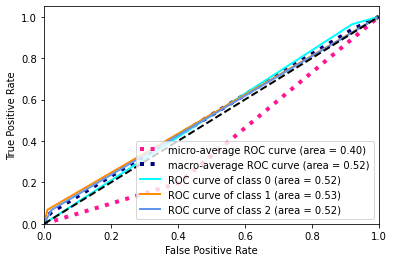

In [ ]:
lp_90 = myLabelPropagation(0.9)

## 95% Unlabelled

/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=10000 was reached without convergence.
  category=ConvergenceWarning


Training time: 373.5650327205658
              precision    recall  f1-score   support

           0       0.15      0.99      0.25      2755
           1       0.65      0.02      0.05      5068
           2       0.76      0.02      0.05     11241

    accuracy                           0.16     19064
   macro avg       0.52      0.34      0.12     19064
weighted avg       0.64      0.16      0.08     19064



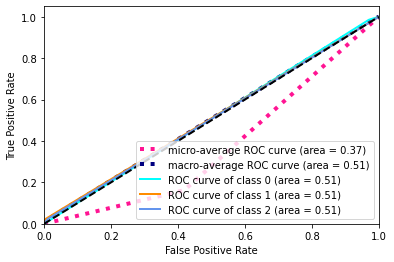

In [ ]:
lp_95 = myLabelPropagation(0.95)

In [ ]:
lp_result = [lp_base, lp_10, lp_20, lp_50, lp_90, lp_95]

In [ ]:
#lp_result = [0.81, 0.80, 0.79, 0.69, 0.19, 0.16 ]

# Label Spreading

In [ ]:
def myLabelSpreading(ratio):
  masked_labels, unlabeled_set = removeLabels(train_dataset, train_labels, 1-ratio)
  mySpred = LabelSpreading(kernel='knn')
  start = time.time()
  mySpred.fit(train_dataset, masked_labels)
  stop = time.time()
  print("Training time: " + str(stop - start))
  pred = np.array(mySpred.predict(test_dataset))
  print(classification_report(test_labels,pred))
  drawROC(pred)
  return mySpred.score(test_dataset, test_labels)

## Fully supervised - Baseline

Training time: 335.0421578884125
              precision    recall  f1-score   support

           0       0.83      0.44      0.57      2755
           1       0.78      0.65      0.71      5068
           2       0.80      0.95      0.87     11241

    accuracy                           0.80     19064
   macro avg       0.80      0.68      0.72     19064
weighted avg       0.80      0.80      0.78     19064



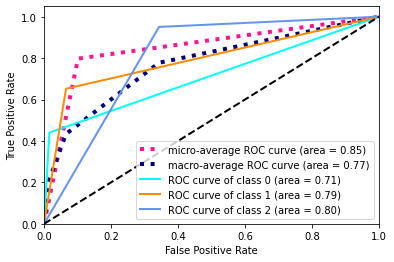

In [ ]:
ls_base = myLabelSpreading(0)

## 10% Unlabelled

Training time: 362.39682269096375
              precision    recall  f1-score   support

           0       0.80      0.43      0.56      2755
           1       0.77      0.63      0.70      5068
           2       0.79      0.94      0.86     11241

    accuracy                           0.79     19064
   macro avg       0.79      0.67      0.70     19064
weighted avg       0.79      0.79      0.77     19064



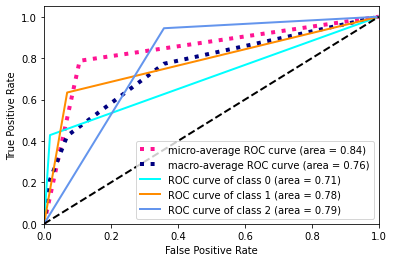

In [ ]:
ls_10 = myLabelSpreading(0.1)

## 20% Unlabelled

Training time: 324.0412859916687
              precision    recall  f1-score   support

           0       0.80      0.42      0.55      2755
           1       0.76      0.62      0.68      5068
           2       0.79      0.94      0.86     11241

    accuracy                           0.78     19064
   macro avg       0.78      0.66      0.70     19064
weighted avg       0.78      0.78      0.77     19064



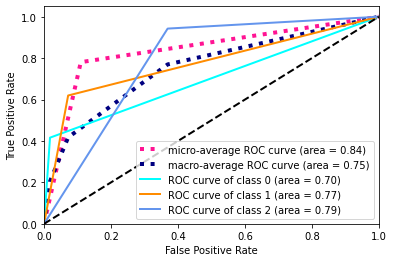

In [ ]:
ls_20 = myLabelSpreading(0.2)

## 50% Unlabelled

/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Training time: 339.6980345249176
              precision    recall  f1-score   support

           0       0.76      0.38      0.51      2755
           1       0.73      0.60      0.66      5068
           2       0.77      0.93      0.84     11241

    accuracy                           0.76     19064
   macro avg       0.75      0.64      0.67     19064
weighted avg       0.76      0.76      0.75     19064



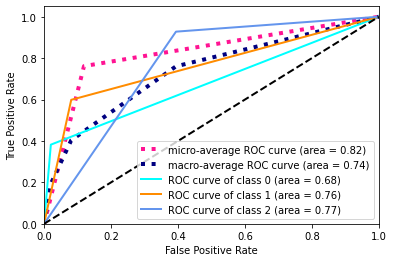

In [ ]:
ls_50 = myLabelSpreading(0.5)

## 90% Unlabelled

/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Training time: 347.4747312068939
              precision    recall  f1-score   support

           0       0.28      0.40      0.33      2755
           1       0.55      0.38      0.45      5068
           2       0.71      0.73      0.72     11241

    accuracy                           0.59     19064
   macro avg       0.51      0.50      0.50     19064
weighted avg       0.61      0.59      0.59     19064



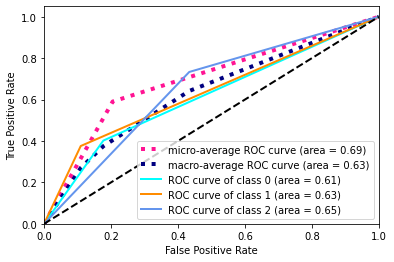

In [ ]:
ls_90 = myLabelSpreading(0.9)

## 95% Unlabelled

/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Training time: 351.90089678764343
              precision    recall  f1-score   support

           0       0.19      0.49      0.28      2755
           1       0.49      0.26      0.34      5068
           2       0.68      0.57      0.62     11241

    accuracy                           0.48     19064
   macro avg       0.46      0.44      0.41     19064
weighted avg       0.56      0.48      0.50     19064



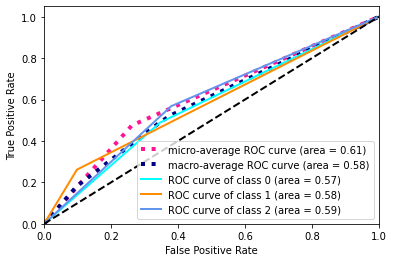

In [ ]:
ls_95 = myLabelSpreading(0.95)

In [ ]:
ls_result = [ls_base, ls_10, ls_20, ls_50, ls_90, ls_95]

In [ ]:
#ls_result = [0.80, 0.79, 0.78, 0.76, 0.59, 0.49 ]

# Self-Training with Random Forest

In [ ]:
def selfLearning(rate):
  labelled_dataset, unlabelled_dataset, labelled_labels, unlabelled_labels = train_test_split(train_dataset, train_labels, test_size=rate)
  count = 0
  start = time.time()
  myRF = RandomForestClassifier(criterion='gini', class_weight='balanced')
  while True:   
    myRF = RandomForestClassifier(criterion='gini', class_weight='balanced')
    myRF.fit(labelled_dataset, labelled_labels)
    pred_probs = myRF.predict_proba(unlabelled_dataset)
    pseudo_labels = myRF.predict(unlabelled_dataset)

    df_pred_prob = pd.DataFrame([])
    df_pred_prob['class_0'] = pred_probs[:,0]
    df_pred_prob['class_1'] = pred_probs[:,1]
    df_pred_prob['class_2'] = pred_probs[:,2]
    df_pred_prob['pseudo_labels'] = pseudo_labels
    df_pred_prob.index = unlabelled_dataset.index

    selected_samples = pd.concat([df_pred_prob.loc[df_pred_prob['class_0'] >= 0.99],
                  df_pred_prob.loc[df_pred_prob['class_1'] >= 0.99],
                  df_pred_prob.loc[df_pred_prob['class_2'] >= 0.99]], axis=0)

    if len(selected_samples) == 0:
      break
    else:
      labelled_dataset = pd.concat([labelled_dataset, unlabelled_dataset.loc[selected_samples.index]], axis=0)
      labelled_labels = pd.concat([labelled_labels, selected_samples.pseudo_labels])   
      unlabelled_dataset = unlabelled_dataset.drop(index=selected_samples.index)
      print("Iteration #" + str(count) + ":  " + str(len(selected_samples)) + " new samples added | " + str(len(unlabelled_dataset)) + " unlabeled data remaining")
      count += 1

  stop = time.time()
  print("Self-training result: ") 
  print("Training time: " + str(stop - start)) 
  rfPred = myRF.predict(test_dataset)
  print(classification_report(test_labels,rfPred))
  drawROC(rfPred)
  return myRF.score(test_dataset, test_labels)

## Fully supervised - Baseline

In [ ]:
myRF = RandomForestClassifier(criterion='gini', class_weight='balanced')
start = time.time()
myRF.fit(train_dataset, train_labels)
stop = time.time()
print("Training time: " + str(stop - start))

Training time: 8.22668194770813


In [ ]:
rfPred = myRF.predict(test_dataset)
st_base = myRF.score(test_dataset, test_labels)
print(classification_report(test_labels, rfPred))

              precision    recall  f1-score   support

           0       0.85      0.70      0.76      2755
           1       0.86      0.68      0.76      5068
           2       0.86      0.98      0.91     11241

    accuracy                           0.86     19064
   macro avg       0.85      0.78      0.81     19064
weighted avg       0.86      0.86      0.85     19064



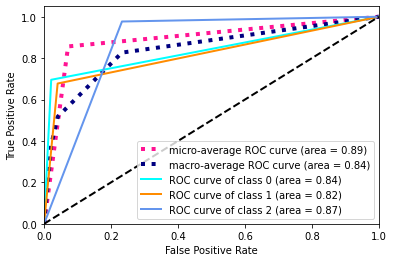

In [ ]:
drawROC(rfPred) 

## 10% Unlabelled

Iteration #0:  39 new samples added | 3832 unlabeled data remaining
Iteration #1:  29 new samples added | 3803 unlabeled data remaining
Iteration #2:  14 new samples added | 3789 unlabeled data remaining
Iteration #3:  12 new samples added | 3777 unlabeled data remaining
Iteration #4:  14 new samples added | 3763 unlabeled data remaining
Iteration #5:  12 new samples added | 3751 unlabeled data remaining
Iteration #6:  13 new samples added | 3738 unlabeled data remaining
Iteration #7:  7 new samples added | 3731 unlabeled data remaining
Iteration #8:  8 new samples added | 3723 unlabeled data remaining
Iteration #9:  10 new samples added | 3713 unlabeled data remaining
Iteration #10:  6 new samples added | 3707 unlabeled data remaining
Iteration #11:  5 new samples added | 3702 unlabeled data remaining
Iteration #12:  10 new samples added | 3692 unlabeled data remaining
Iteration #13:  4 new samples added | 3688 unlabeled data remaining
Iteration #14:  5 new samples added | 3683 unlabe

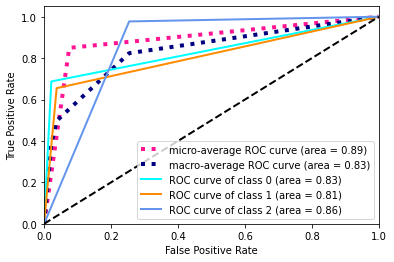

In [ ]:
st_10 = selfLearning(0.1)

## 20% Unlabelled

Iteration #0:  69 new samples added | 7672 unlabeled data remaining
Iteration #1:  52 new samples added | 7620 unlabeled data remaining
Iteration #2:  23 new samples added | 7597 unlabeled data remaining
Iteration #3:  30 new samples added | 7567 unlabeled data remaining
Iteration #4:  21 new samples added | 7546 unlabeled data remaining
Iteration #5:  20 new samples added | 7526 unlabeled data remaining
Iteration #6:  16 new samples added | 7510 unlabeled data remaining
Iteration #7:  15 new samples added | 7495 unlabeled data remaining
Iteration #8:  13 new samples added | 7482 unlabeled data remaining
Iteration #9:  12 new samples added | 7470 unlabeled data remaining
Iteration #10:  2 new samples added | 7468 unlabeled data remaining
Iteration #11:  16 new samples added | 7452 unlabeled data remaining
Iteration #12:  8 new samples added | 7444 unlabeled data remaining
Iteration #13:  6 new samples added | 7438 unlabeled data remaining
Iteration #14:  7 new samples added | 7431 unla

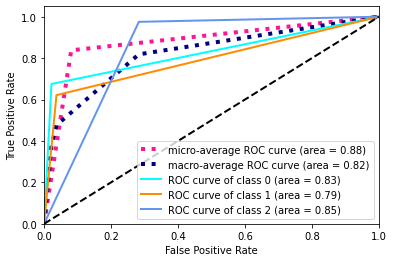

In [ ]:
st_20 = selfLearning(0.2)

## 50% Unlabelled

Iteration #0:  78 new samples added | 19274 unlabeled data remaining
Iteration #1:  56 new samples added | 19218 unlabeled data remaining
Iteration #2:  56 new samples added | 19162 unlabeled data remaining
Iteration #3:  38 new samples added | 19124 unlabeled data remaining
Iteration #4:  28 new samples added | 19096 unlabeled data remaining
Iteration #5:  34 new samples added | 19062 unlabeled data remaining
Iteration #6:  27 new samples added | 19035 unlabeled data remaining
Iteration #7:  18 new samples added | 19017 unlabeled data remaining
Iteration #8:  27 new samples added | 18990 unlabeled data remaining
Iteration #9:  19 new samples added | 18971 unlabeled data remaining
Iteration #10:  20 new samples added | 18951 unlabeled data remaining
Iteration #11:  22 new samples added | 18929 unlabeled data remaining
Iteration #12:  17 new samples added | 18912 unlabeled data remaining
Iteration #13:  19 new samples added | 18893 unlabeled data remaining
Iteration #14:  20 new samples

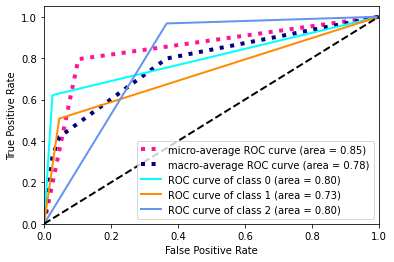

In [ ]:
st_50 = selfLearning(0.5)

## 90% unlabelled

Iteration #0:  14 new samples added | 34820 unlabeled data remaining
Iteration #1:  14 new samples added | 34806 unlabeled data remaining
Iteration #2:  8 new samples added | 34798 unlabeled data remaining
Iteration #3:  13 new samples added | 34785 unlabeled data remaining
Iteration #4:  17 new samples added | 34768 unlabeled data remaining
Iteration #5:  26 new samples added | 34742 unlabeled data remaining
Iteration #6:  14 new samples added | 34728 unlabeled data remaining
Iteration #7:  21 new samples added | 34707 unlabeled data remaining
Iteration #8:  28 new samples added | 34679 unlabeled data remaining
Iteration #9:  18 new samples added | 34661 unlabeled data remaining
Iteration #10:  23 new samples added | 34638 unlabeled data remaining
Iteration #11:  39 new samples added | 34599 unlabeled data remaining
Iteration #12:  29 new samples added | 34570 unlabeled data remaining
Iteration #13:  21 new samples added | 34549 unlabeled data remaining
Iteration #14:  19 new samples 

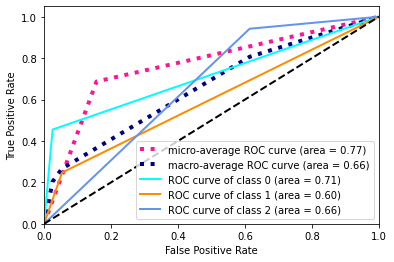

In [ ]:
st_90 = selfLearning(0.9)

## 95%  Unlabelled

Iteration #0:  1 new samples added | 36768 unlabeled data remaining
Iteration #1:  8 new samples added | 36760 unlabeled data remaining
Iteration #2:  1 new samples added | 36759 unlabeled data remaining
Iteration #3:  1 new samples added | 36758 unlabeled data remaining
Iteration #4:  2 new samples added | 36756 unlabeled data remaining
Iteration #5:  1 new samples added | 36755 unlabeled data remaining
Iteration #6:  3 new samples added | 36752 unlabeled data remaining
Iteration #7:  1 new samples added | 36751 unlabeled data remaining
Iteration #8:  3 new samples added | 36748 unlabeled data remaining
Iteration #9:  2 new samples added | 36746 unlabeled data remaining
Iteration #10:  1 new samples added | 36745 unlabeled data remaining
Self-training result: 
Training time: 19.20122194290161
              precision    recall  f1-score   support

           0       0.77      0.33      0.47      2755
           1       0.51      0.21      0.29      5068
           2       0.66      0.9

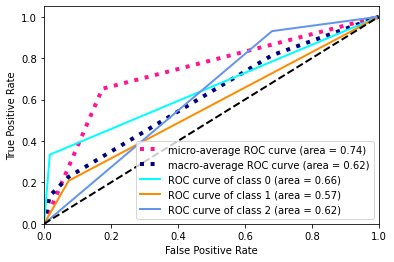

In [ ]:
st_95 = selfLearning(0.95)

In [ ]:
st_result = [st_base, st_10, st_20, st_50, st_90, st_95]

In [ ]:
#st_result = [0.86, 0.84, 0.83, 0.79, 0.69, 0.66 ]

# Levels of Unlabelled Data Table

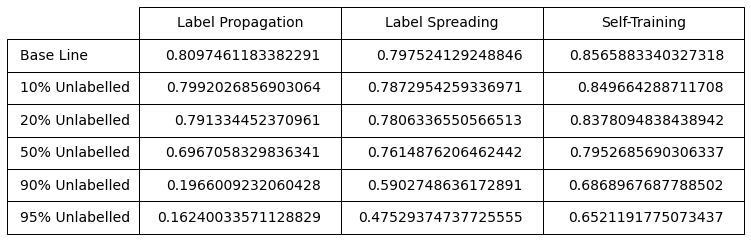

In [ ]:
columns = ['Label Propagation', 'Label Spreading', 'Self-Training']

table_data = np.array([lp_result, ls_result, st_result]).T
            
rows = ['Base Line', '10% Unlabelled', '20% Unlabelled', '50% Unlabelled', '90% Unlabelled', '95% Unlabelled']
table = plt.table(cellText=table_data, colLabels=columns, rowLabels=rows, loc='center')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
table.set_fontsize(16)
table.scale(2,3)
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.show()

# Wilcoxon’s Signed Rank Test

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


No significant differences between  Label Propagation and  Label Spreading
There are significant differences between  Label Propagation and  Self-Training
There are significant differences between  Label Spreading and  Self-Training


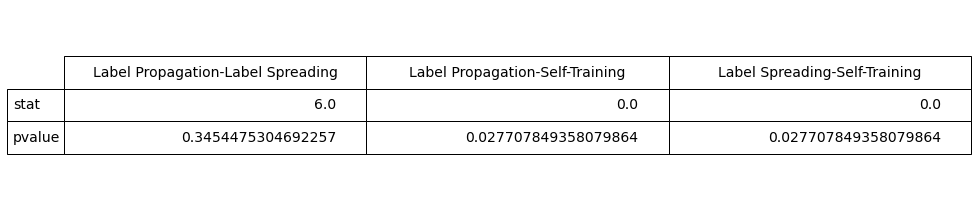

In [ ]:
table_data = table_data.T
k = 10 
results = []
names = []
for i in range(3):
  for j in range(i+1, 3):
    cur_name = columns[i] + "-" + columns[j]
    names.append(cur_name)
    cur_stat, cur_p = wilcoxon(table_data[i], table_data[j])
    if cur_p > 0.05:
      print('No significant differences between ', columns[i], 'and ', columns[j])
    else:
      print('There are significant differences between ', columns[i], 'and ', columns[j])
    results.append([cur_stat, cur_p])

rows = ['stat', 'pvalue']

table = plt.table(cellText=np.transpose(results), colLabels=names, rowLabels=rows, loc='center')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
table.set_fontsize(24)
table.scale(3,3)
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.show()

# Friedman's Test

In [ ]:
stat, p = friedmanchisquare(table_data[0], table_data[1], table_data[2])
print(stat, p)

9.0 0.011108996538242308


Sicne Friedman's statistic gives 9, which is larger than 7.815, thus all algorithms DO NOT perform equally on those 6 data sets.

# Critical Difference

In [ ]:
k = 3
n = 6
q_alpha = 2.343
cd = q_alpha * np.sqrt( (k*(k+1)) / (6*n) )
print("Critical Difference: ", cd)

Critical Difference:  1.352731680711293


# Nemenyi Diagram

In [ ]:
#!pip install orange3

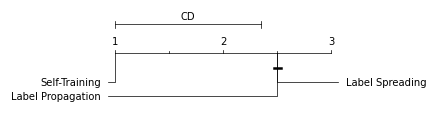

In [ ]:
import Orange
ranks = [[2, 2, 2, 3, 3, 3], [3, 3, 3, 2, 2, 2], [1, 1, 1, 1, 1, 1]]
avranks = np.average(ranks, axis=1)
Orange.evaluation.graph_ranks(avranks, columns, cd=cd, width=6, textspace=1.5)
plt.show()

As demonstrated above, self-learning is the best algorithm in this context.